In [41]:
# load the shampoo sales dataset
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import numpy as np
from pandas import Series
import warnings
import math
from sklearn.metrics import mean_squared_error

In [6]:
def cleaning_df(df, location):
    city_series = series[location]
    city_series = city_series.reset_index()
    city_series.rename({location: 'Temp'}, axis=1, inplace=True) 

    city_series['date'] = pd.to_datetime(city_series['datetime']).dt.date
    city_series['time'] = pd.to_datetime(city_series['datetime']).dt.time
    city_series['time'] = city_series['time'].astype(str)
    
    city_series_fltr = city_series[city_series['time']=="13:00:00"]
    city_series_fltr = city_series_fltr[~city_series_fltr['Temp'].isna()]
    city_series_fltr['Converter'] = -273.15
    city_series_fltr['temp_c'] = city_series_fltr['Temp']+city_series_fltr['Converter']
    city_series_fltr = city_series_fltr.drop(['time','date','Temp', 'Converter'], axis = 1)
    
    return city_series_fltr

In [149]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value) 
    return Series(diff)

In [150]:
# invert differenced value
def inverse_difference(history, yhat, interval=1): 
    return yhat + history[-interval]

In [158]:
def cleaning(df, value = None):
    vancouver_df = cleaning_df(df, 'Vancouver')
    vancouver_df['year'] = pd.to_datetime(vancouver_df['datetime']).dt.year
    y = vancouver_df.drop('year', axis = 1)

    z = y['temp_c']
    z = z.values
    z = z.astype('float32')
    
    if value is not None:
        z = z[:value]
        train_size = int(len(z) * 0.50)
        train, test = z[0:train_size], z[train_size:]
    else: 
        train_size = int(len(z) * 0.50)
        train, test = z[0:train_size], z[train_size:]
    return z, train, test

In [165]:
def rolling_forcast(train, test):
    history = [x for x in train]
    # rolling forecasts
    predictions = list()
    for i in range(1, len(test)):
      # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff, order=(3,1,3))
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year) 
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
    rmse = math.sqrt(mean_squared_error(test[:-1], predictions)) 
    print('RMSE: %.3f' % rmse)
    pyplot.plot(test)
    pyplot.plot(predictions, color='red') 
    pyplot.show()


>Predicted=2.083, Expected=3.110
>Predicted=4.939, Expected=8.440
>Predicted=6.525, Expected=8.060
>Predicted=7.595, Expected=2.750
>Predicted=1.517, Expected=0.520
>Predicted=-2.681, Expected=4.210
>Predicted=6.794, Expected=4.400
>Predicted=5.081, Expected=4.390
>Predicted=1.523, Expected=2.305
>Predicted=3.209, Expected=1.579
>Predicted=0.533, Expected=4.293
>Predicted=5.280, Expected=4.022
>Predicted=4.094, Expected=4.595
>Predicted=7.999, Expected=9.330
>Predicted=8.313, Expected=8.405
>Predicted=3.951, Expected=7.410
>Predicted=4.692, Expected=6.597
>Predicted=8.004, Expected=3.634
>Predicted=2.061, Expected=4.235
>Predicted=4.188, Expected=1.870
>Predicted=1.814, Expected=5.950
>Predicted=5.136, Expected=2.730
>Predicted=5.296, Expected=2.130
>Predicted=0.762, Expected=1.550
>Predicted=3.455, Expected=2.660
>Predicted=9.587, Expected=5.150
>Predicted=4.877, Expected=4.230
>Predicted=2.833, Expected=4.730
>Predicted=4.999, Expected=7.330
>Predicted=5.929, Expected=6.780
>Predicte

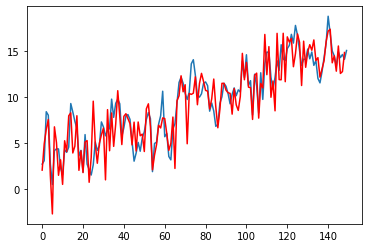

In [166]:
warnings.filterwarnings("ignore")
series = read_csv('temperature.csv', header=0, index_col=0, parse_dates=True,squeeze=True) 
z, train, test = cleaning(series, 300)
rolling_forcast(train, test)